In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Shane's Tag

In [2]:
#Loading the raster
image_raster = rio.open('hxip_m_3711955_clipped_11_100.tif')

#Type of Coordinates
print(image_raster.crs)

#Loading the data read() returns array with shape (bands, rows, columns)
image_data = image_raster.read()

print(image_data.shape)
#Loading the coordinate data
#Returns a mesh grid, unknown units
coordinate_data_x = np.zeros((image_raster.height, image_raster.width))
coordinate_data_y = np.zeros((image_raster.height, image_raster.width))

for i in range(image_raster.height):
    for j in range(image_raster.width):
        coords = image_raster.xy(i, j)
        coordinate_data_x[i,j]=coords[0]
        coordinate_data_y[i,j]=coords[1]

#Checking everything worked
print(image_data.shape)
print(image_data)

print(coordinate_data_x.shape)
print(coordinate_data_x)

print(coordinate_data_y.shape)
print(coordinate_data_y)

EPSG:32611
(4, 918, 1060)
(4, 918, 1060)
[[[ 39. 119.  23. ...  28.  37.  35.]
  [ 38.  29.  97. ...  31.  40.  43.]
  [ 36.  37.  87. ...  29.  35.  39.]
  ...
  [ 41. 133.  56. ... 131. 142. 149.]
  [ 14. 186.  30. ...  63.  43. 121.]
  [ 18. 130. 112. ...  15.  13.  12.]]

 [[ 63. 146.  40. ...  56.  67.  62.]
  [ 65.  36. 100. ...  61.  67.  74.]
  [ 51.  56. 117. ...  55.  68.  70.]
  ...
  [ 43. 118.  59. ... 131. 139. 142.]
  [ 19. 177.  35. ...  63.  40. 117.]
  [ 22. 124. 110. ...  18.  16.  17.]]

 [[ 32. 110.  16. ...  24.  35.  34.]
  [ 31.  19.  85. ...  30.  38.  45.]
  [ 30.  30.  77. ...  28.  35.  40.]
  ...
  [ 31.  94.  40. ... 115. 119. 120.]
  [ 10. 167.  14. ...  55.  33. 104.]
  [ 16.  99.  75. ...  14.  13.   7.]]

 [[178. 190.  71. ... 172. 175. 168.]
  [180. 112. 165. ... 181. 180. 179.]
  [162. 177. 189. ... 177. 182. 179.]
  ...
  [ 90. 147.  83. ... 126. 136. 150.]
  [ 62. 170. 146. ...  96.  97. 182.]
  [ 29. 158. 146. ...  19.  15.  18.]]]
(918, 1060)
[[3

In [29]:
#Loading classification data
classification_raster = rio.open('hxip_m_3711955_clipped_11_100_taggedApril5th2022.tif')
classification = classification_raster.read()

coordinate_data_x_classification = np.zeros((classification_raster.height, classification_raster.width))
coordinate_data_y_classification = np.zeros((classification_raster.height, classification_raster.width))

for i in range(classification_raster.height):
    for j in range(classification_raster.width):
        coords = classification_raster.xy(i, j)
        coordinate_data_x_classification[i,j]=coords[0]
        coordinate_data_y_classification[i,j]=coords[1]


        
print(classification.shape)
#merge the green graass with green trees.
for x in range(0,918):
    for y in range(0,1060):
        if(classification[0,x,y] == 6):
            classification[0,x,y]=4
        if(classification[0,x,y] == 7):
            classification[0,x,y]=6
        if(classification[0,x,y] == 8):
            classification[0,x,y]=7

#print(classification)

#print(coordinate_data_x_classification.shape)
#print(coordinate_data_x_classification)

#print(coordinate_data_y_classification.shape)
#print(coordinate_data_y_classification)

(1, 918, 1060)


In [30]:
#Machine Learning "Features" Data set
#[band0, band1, band2, band3, x, y]

band0 = image_data[0].flatten()
band1 = image_data[1].flatten()
band2 = image_data[2].flatten()
band3 = image_data[3].flatten()


features_data = np.array([band0,band1,band2,band3])
X = features_data.T
image = X

#Tagged Data
y = classification[0].flatten()
print(np.max(classification))
y = y.astype(int)

#Cuts (Train/Test Split):
X = X[y!=0]
y = y[y!=0]

print(X.shape)
print(y.shape)

7.0
(153912, 4)
(153912,)


In [31]:
#Scaling of All Data Sets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)


#For Supervised Learning
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)
image_scaled = scaler.transform(image)

In [32]:
#Neural Network

#Finding the most accurate neural network configuration 
from numpy import arange
from sklearn.neural_network import MLPClassifier

formerTrain = 0
formerTest = 0
for i in [15]:
    hiddenlayer = []
    for j in range(4,10):
        hiddenlayer.append(i)
        mlp = MLPClassifier(solver = 'sgd', activation = 'tanh', 
                    random_state = 1, hidden_layer_sizes = j)
        mlp.fit(X_train_scaled, y_train)
        
        currentTrain = mlp.score(X_train_scaled, y_train)
        currentTest = mlp.score(X_test_scaled, y_test)
        
        #Print all values just in case we need to compare values
        print("Accuracy of Training Set {} neurons {} hidden layers: ".format(i, j),
              "{:.4f}".format(currentTrain))
        print("Accuracy of Test Set {} neurons {} hidden layers: ".format(i, j),
              "{:.4f}".format(currentTest))
        
        if currentTest>formerTest:
            neurons = i
            layers = j
            formerTrain = currentTrain
            formerTest = currentTest
            layersOp = hiddenlayer

print("Optimal Parameters:\n", 
      "Neurons= {} Layers= {}\n".format(neurons, layers),
      "Training Score = {:.4f}\n".format(formerTrain),
      "Test Score = {:.4f}".format(formerTest))

Accuracy of Training Set 15 neurons 4 hidden layers:  0.9280
Accuracy of Test Set 15 neurons 4 hidden layers:  0.9300
Accuracy of Training Set 15 neurons 5 hidden layers:  0.9374
Accuracy of Test Set 15 neurons 5 hidden layers:  0.9400
Accuracy of Training Set 15 neurons 6 hidden layers:  0.9395
Accuracy of Test Set 15 neurons 6 hidden layers:  0.9410
Accuracy of Training Set 15 neurons 7 hidden layers:  0.9402
Accuracy of Test Set 15 neurons 7 hidden layers:  0.9423
Accuracy of Training Set 15 neurons 8 hidden layers:  0.9402
Accuracy of Test Set 15 neurons 8 hidden layers:  0.9423
Accuracy of Training Set 15 neurons 9 hidden layers:  0.9409
Accuracy of Test Set 15 neurons 9 hidden layers:  0.9433
Optimal Parameters:
 Neurons= 15 Layers= 9
 Training Score = 0.9409
 Test Score = 0.9433


In [33]:
from sklearn.neural_network import MLPClassifier

#Predicting whole data set

mlp = MLPClassifier(solver = 'sgd', activation = 'tanh', 
                    random_state = 0, hidden_layer_sizes = [15,15,15,15,15,15,15])
mlp.fit(X_scaled, y)

y_predict = mlp.predict(image_scaled)

print(y_predict)
print(y)

image_predict = np.reshape(y_predict, image_data[0].shape)

print(image_predict.shape)

[4 4 4 ... 4 4 4]
[4 4 4 ... 6 6 6]
(918, 1060)


['houses', 'road', 'asphalt', 'green veg', 'dead trees', 'dry grass', 'water']


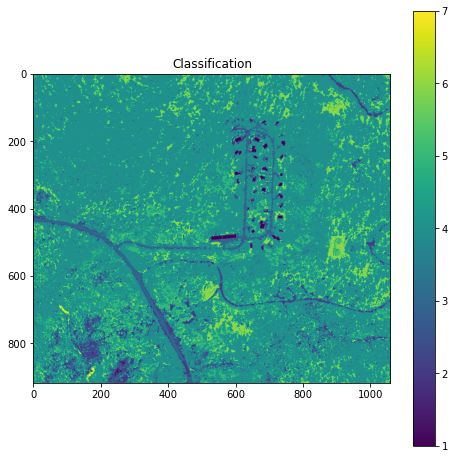

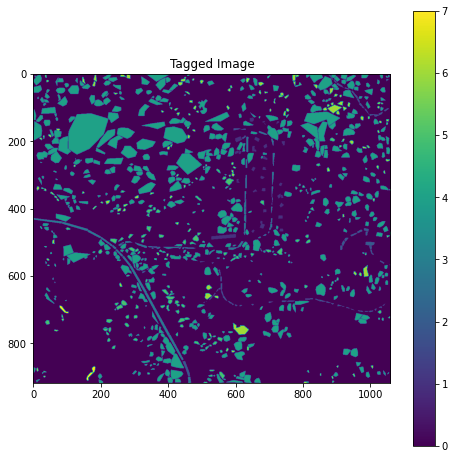

In [34]:
#Plotting Prediction Classification
targets = ['houses', 'road', 'asphalt', 'green veg', 'dead trees', 'dry grass', 'water']

print(targets)
plt.figure(figsize = (8,8))
plt.imshow(image_predict)
plt.title("Classification")
plt.colorbar()
plt.show()

plt.figure(figsize = (8,8))
plt.imshow(classification[0])
plt.title("Tagged Image")
plt.colorbar()
plt.show()

In [35]:
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

xmin,ymin,xmax,ymax = [coordinate_data_x_classification.min(),
                       coordinate_data_y_classification.min(),
                       coordinate_data_x_classification.max(),
                       coordinate_data_y_classification.max()]
nrows,ncols = image_predict.shape
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0,-yres)   

output_raster = gdal.GetDriverByName('GTiff').Create('neuralnetclassification.tif',ncols, nrows, 1 ,gdal.GDT_Float32)
output_raster.SetGeoTransform(geotransform)  
srs = osr.SpatialReference()                 
srs.ImportFromEPSG(32611)                    
                                             
output_raster.SetProjection( srs.ExportToWkt() )   
output_raster.GetRasterBand(1).WriteArray(image_predict)

output_raster.FlushCache()

In [41]:
import matplotlib.axes as ax
from matplotlib import colors

targets = ['houses', 'road', 'asphalt', 'green trees', 'dead trees', 'dry grass', 'water']
prob = mlp.predict_proba(X_scaled)

#print(prob.shape)
#print(prob)

prob_1 = prob[y==1]
prob_2 = prob[y==2]
prob_3 = prob[y==3]
prob_4 = prob[y==4]
prob_5 = prob[y==5]
prob_6 = prob[y==6]
prob_7 = prob[y==7]

def probability_graph(prob_matrix, class_num):
    bins = np.linspace(0,1,20)
    matrix = np.zeros((len(bins)-1,7))

    for j in range(7):
        hist,edges =np.histogram(prob_matrix[:,j],bins=bins)
        matrix[:,j]=np.flip(hist)
        
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.imshow(matrix,extent=[0.5,8.5,0,100], aspect='auto', cmap="jet", norm=colors.LogNorm())
    ax.set_xticks([1,2,3,4,5,6,7])
    ax.set_xticklabels(targets)
    plt.title("Probability of Tagged {}:{} Log scale".format(class_num,targets[class_num-1]))
    plt.colorbar()
    plt.show()

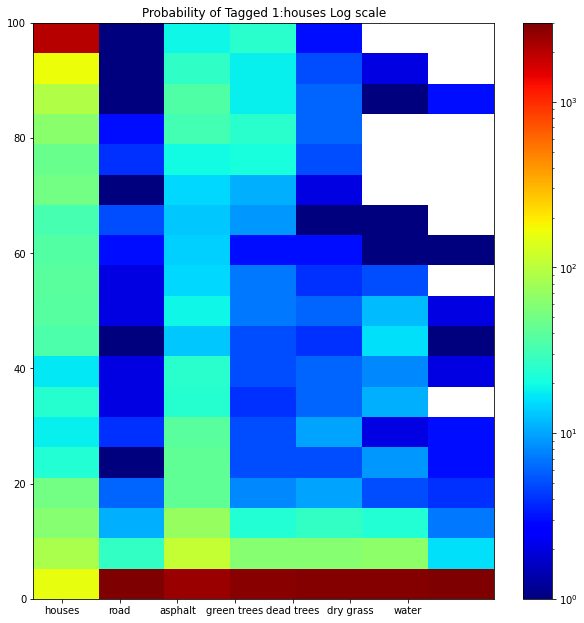

In [42]:
probability_graph(prob_1, 1)

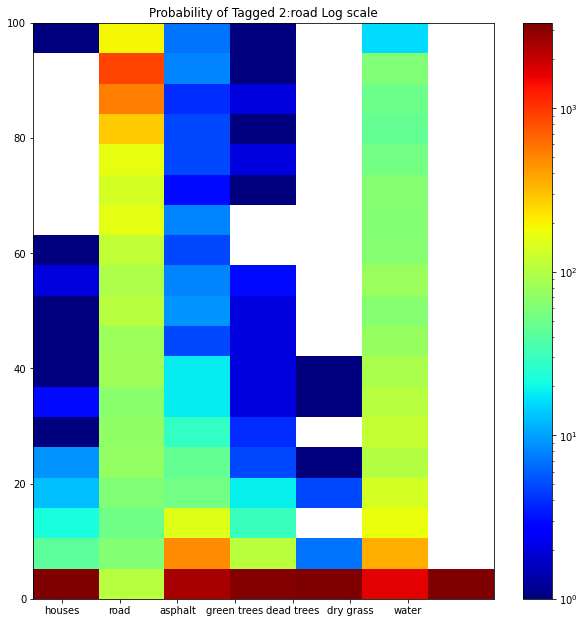

In [43]:
probability_graph(prob_2, 2)

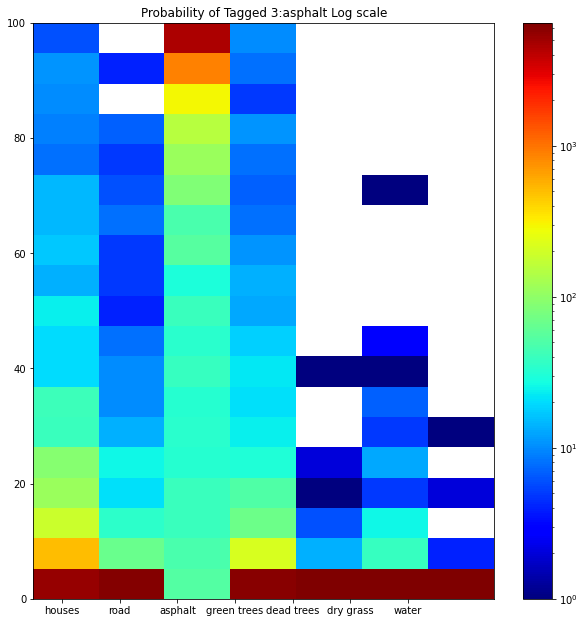

In [44]:
probability_graph(prob_3, 3)

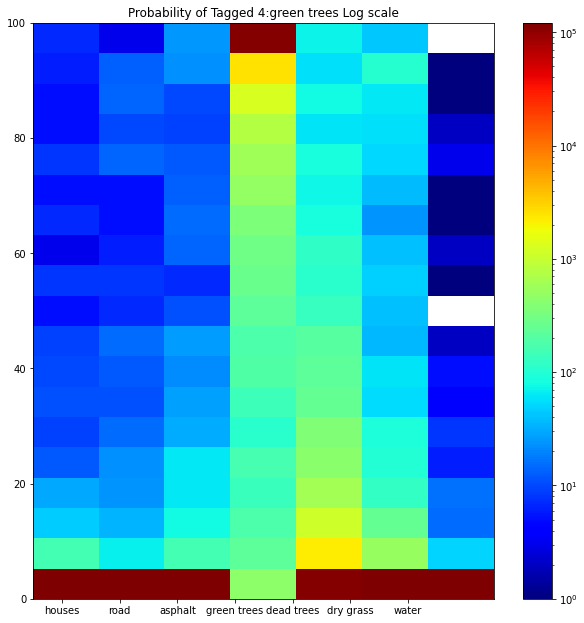

In [45]:
probability_graph(prob_4, 4)

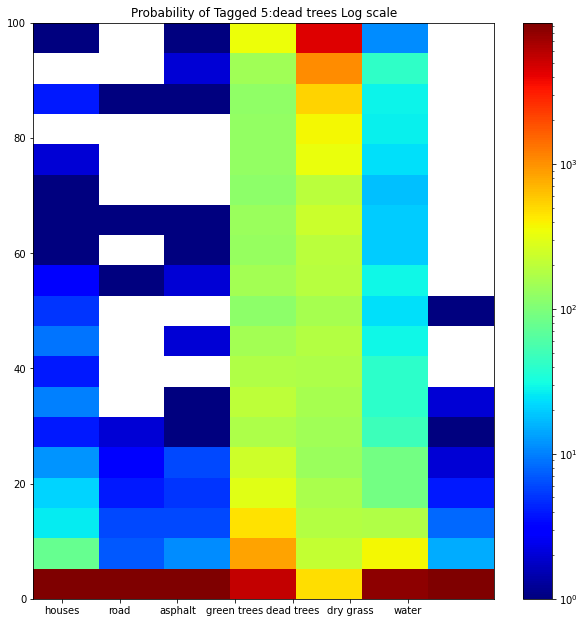

In [46]:
probability_graph(prob_5, 5)

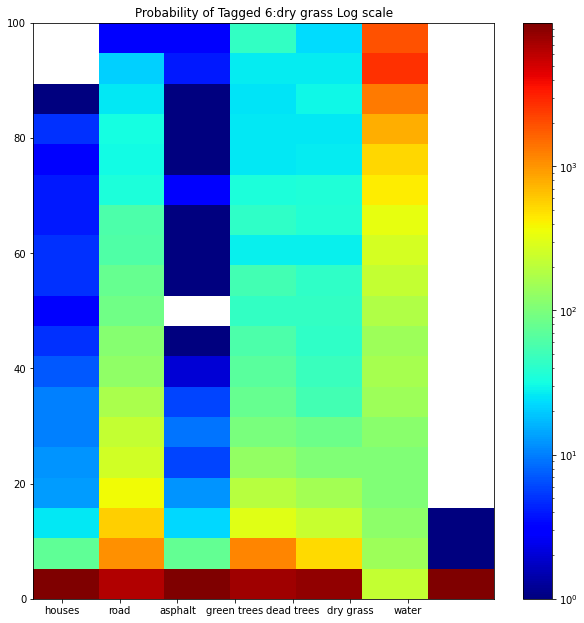

In [47]:
probability_graph(prob_6, 6)

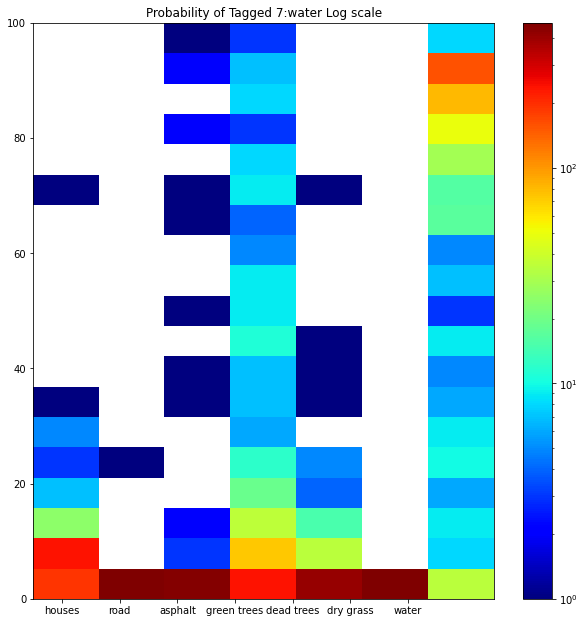

In [48]:
probability_graph(prob_7, 7)

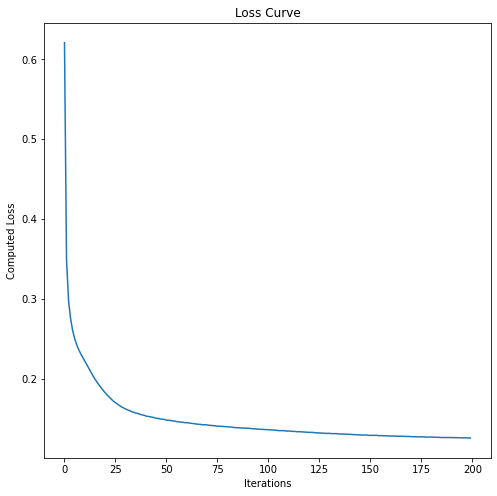

In [49]:
loss=mlp.loss_curve_

plt.figure(figsize=(8,8))
plt.plot(loss)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Computed Loss")
plt.show()